In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "geodatasets",
#     "geopandas",
#     "ipywidgets",
#     "lonboard",
#     "numpy",
#     "palettable",
#     "pandas",
#     "shapely",
# ]
# ///

# Categorical Filtering with the DataFilterExtension

The `DataFilterExtension` adds GPU-based data filtering functionalities to layers, allowing the layer to show/hide objects based on user-defined properties.

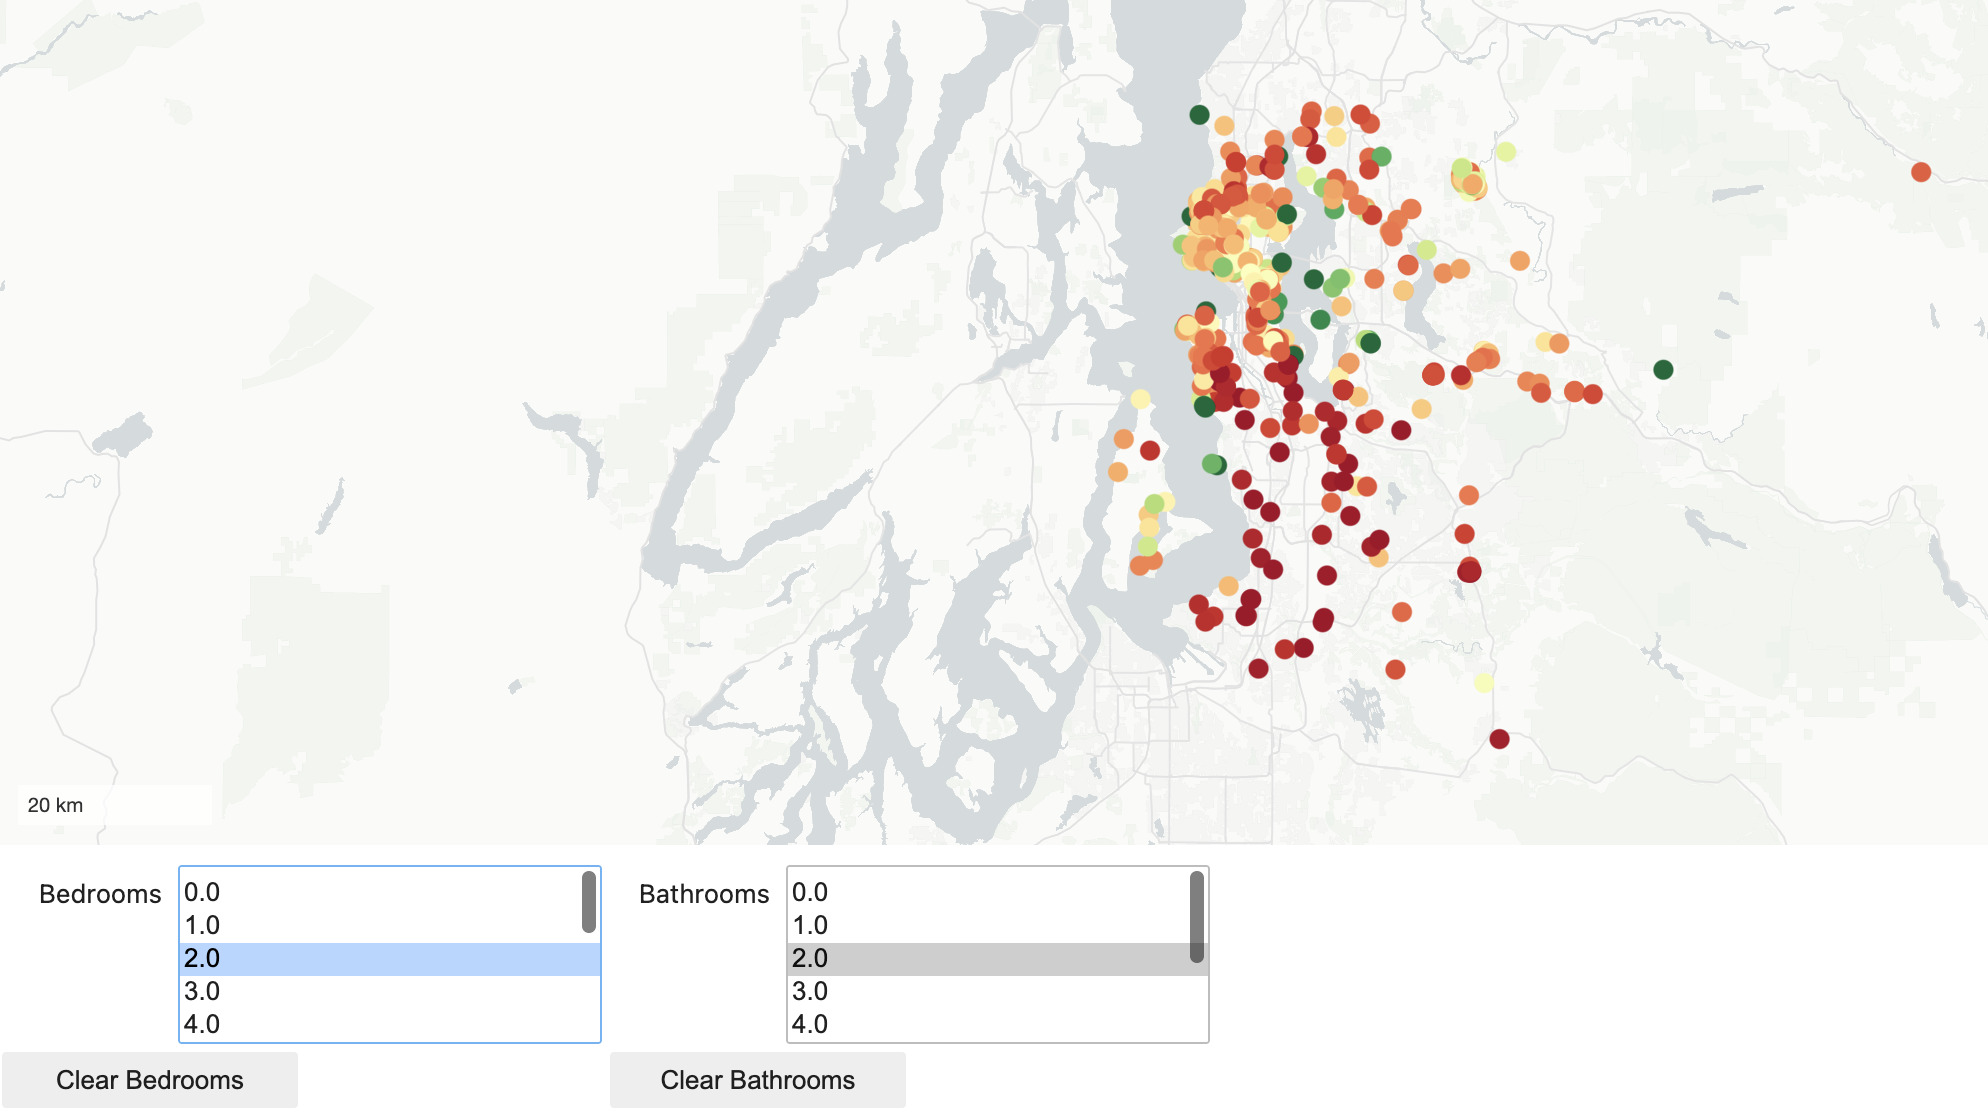

## Dependencies

Install [`uv`](https://docs.astral.sh/uv) and then launch this notebook with:

```
uvx juv run examples/data-filter-extension-categorical.ipynb
```

(The `uvx` command is included when installing `uv`).

## Categorical Filtering
In this example the `DataFilterExtension` will be used to filter the display the home sales dataset from geodatasets based on the number of bedrooms, bathrooms.

To demonstrate, we'll create:

1. A GeoPandas GeoDataFrame of home sales data.
2. A Lonboard ScatterPlotLayer from the GeoDataFrame that has a DataFilterExtension set up for categorical filtering.
3. Some IPyWidgets linked to the ScatterPlotLayer's `filter_categories` property to allow us to interactively filter the points on the map.

### Imports

In [2]:
import geodatasets
import geopandas
import traitlets
from ipywidgets import Button, HBox, SelectMultiple, VBox
from palettable.colorbrewer.diverging import RdYlGn_11

import lonboard
from lonboard import Map, ScatterplotLayer
from lonboard.layer_extension import DataFilterExtension

### Reading the Home Sales Data

This example makes use the geodatasets python package to access some spatial data easily.

Calling geodatasets.get_path() will download data the specified data to the machine and return the path to the downloaded file. If the file has already been downloaded it will simply return the path to the file. [See downloading and caching](https://geodatasets.readthedocs.io/en/latest/introduction.html#downloading-and-caching) for further details.

In [3]:
home_sales_df = geopandas.read_file(geodatasets.get_path("geoda.home_sales"))[
    ["price", "bedrooms", "bathrooms", "geometry"]
]
home_sales_df

,price,bedrooms,bathrooms,geometry
0,221900.0,3.0,1.0,POINT (-122.257 47.5112)
1,538000.0,3.0,2.0,POINT (-122.319 47.721)
2,180000.0,2.0,1.0,POINT (-122.233 47.7379)
3,604000.0,4.0,3.0,POINT (-122.393 47.5208)
4,510000.0,3.0,2.0,POINT (-122.045 47.6168)
...,...,...,...,...
21608,360000.0,3.0,2.0,POINT (-122.346 47.6993)
21609,400000.0,4.0,2.0,POINT (-122.362 47.5107)
21610,402101.0,2.0,0.0,POINT (-122.299 47.5944)
21611,400000.0,3.0,2.0,POINT (-122.069 47.5345)


### Create the `ScatterplotLayer` with a  `DataFilterExtension` extension for categorical filtering

The `DataFilterExtension` will be created with `filter_size=None` to indicate we do not want to use a range filter, and `category_size=2` to indicate we want to use two different categories from the data to filter the data with explicit values.

The points in the layer will be symbolized based on a continuous colormap of the price. Lower priced homes will be red, and higher priced homes will be green. We'll throw out the upper and lower 5% of value from the color map so the upper and lower outliers do not influence the colormap.

In [4]:
min_bound = home_sales_df["price"].quantile(0.05)
max_bound = home_sales_df["price"].quantile(0.95)
price = home_sales_df["price"]
normalized_price = (price - min_bound) / (max_bound - min_bound)

home_sale_layer = ScatterplotLayer.from_geopandas(
    home_sales_df,
    get_fill_color=lonboard.colormap.apply_continuous_cmap(normalized_price, RdYlGn_11),
    radius_min_pixels=5,
    extensions=[
        DataFilterExtension(filter_size=None, category_size=2),
    ],
    get_filter_category=home_sales_df[["bedrooms", "bathrooms"]].values,
    filter_categories=[[], []],
)

### Create the iPyWidgets to interact with the `DataFilterExtension`

Since we want to only display the points which are tied to specific number of bedrooms and bathrooms we'll:

1.  Create two ipywidgets `SelectMultiple` widgets which will hold the different numbers of bedrooms and bathrooms in the home sales data.
2.  Create two ipywidgets `Button` widgets which will clear the selected values for the bedrooms and bathrooms.
4.  Observe the changes made to the `SelectMultiple` widgets to update the layer's `filter_categories` property.

This will enable us to select one or more number of bedrooms or bathrooms and have the map instantly react to display only the data that matches the selections.  If a select widget does not have a selection, all the values from that selector will be used.

In [5]:
unique_bedrooms_values = list(home_sales_df["bedrooms"].sort_values().unique())
unique_bathrooms_values = list(home_sales_df["bathrooms"].sort_values().unique())

bedrooms_select = SelectMultiple(description="Bedrooms", options=unique_bedrooms_values)
bathrooms_select = SelectMultiple(
    description="Bathrooms",
    options=unique_bathrooms_values,
)


def on_select_change(_: traitlets.utils.bunch.Bunch = None) -> None:
    """Set the layer's filter_categories property based on widget selections."""
    bedrooms = bedrooms_select.value
    bathrooms = bathrooms_select.value
    if len(bedrooms) == 0:
        bedrooms = unique_bedrooms_values
    if len(bathrooms) == 0:
        bathrooms = unique_bathrooms_values
    home_sale_layer.filter_categories = [bedrooms, bathrooms]


bedrooms_select.observe(on_select_change, "value")
bathrooms_select.observe(on_select_change, "value")

clear_bedrooms_button = Button(description="Clear Bedrooms")


def clear_bedrooms(_: Button) -> None:
    bedrooms_select.value = []


clear_bedrooms_button.on_click(clear_bedrooms)

clear_bathrooms_button = Button(description="Clear Bathrooms")


def clear_bathrooms(_: Button) -> None:
    bathrooms_select.value = []


clear_bathrooms_button.on_click(clear_bathrooms)

home_sale_map = Map(
    layers=[home_sale_layer],
    basemap=lonboard.basemap.MaplibreBasemap(),
)
on_select_change()  # fire the function once to initially set the layer's filter_categories, and display all points

display(home_sale_map)
display(
    HBox(
        [
            VBox([bedrooms_select, clear_bedrooms_button]),
            VBox([bathrooms_select, clear_bathrooms_button]),
        ],
    ),
)